In [15]:
from brian2 import *
import time
from brian2tools import *
import numpy as np

## distribution parameters processing

In [16]:
#this function takes as input the first and second momentum of the weights population given in supp table 1 
#it transforms the average and var into the average and std of a lognormal distribution (formulas taken from wikipedia)

def process_params(av, av2):
    var = (av2 - av**2)
    
    mu = np.log(av**2/(av**2 + var)**(1/2))
    sigma = np.log(1 + var/av**2)
    
    return mu, sigma

In [17]:
#the weight distribution parameters are processed and stored in non-array variables to be passed to brian
#in the future let's just do this computation and store the values in a file to read

avs = np.array([0.37, 0.66, 0.44, 0.54])
avs2 = np.array([0.26, 0.65, 0.49, 0.53])

lognormal_mu = []
lognormal_std = []

for i in range(len(avs)):
    mu, sigma = process_params(avs[i], avs2[i])
    lognormal_mu.append(mu)
    lognormal_std.append(sigma)
    
ee_mu = lognormal_mu[0]
ee_std = lognormal_std[0]
ie_mu = lognormal_mu[1]
ie_std = lognormal_std[1]
ei_mu = lognormal_mu[2]
ei_std = lognormal_std[2]
ii_mu = lognormal_mu[3]
ii_std = lognormal_std[3]

In [18]:
lognormal_mu, lognormal_std

([-1.3149677227044294,
  -0.6156394298771044,
  -1.285286160200928,
  -0.9149331426296491],
 [0.6414308987211246,
  0.40024797183087735,
  0.9286112162621957,
  0.5974940064116644])

## defininig the network

In [19]:
#define network parameters

#total size of the network
N = 40000

#threshold, reset and refractory parameters
v_theta = 33*mV
v_reset = 24.75*mV
tau_ref = 1*ms

#indices that delimit inhibitory and excitatory populations 20/80
first_inh = 0
last_inh = int(0.2*N)
first_exc = last_inh
last_exc = N


#these are additional parameters to play with resizing of weights (in paper would be 1)
#g_E = 1/0.8*N
#g_I = 1/0.2*N
g_E = 1
g_I = 1


#External drive to each population

H_in = 57.8*mV
H_ex = 77.6*mV


#clear brian scope to reset any past variables
start_scope()

#define the model that each neuron will follow
tau = 10*ms
eqs = '''
dv/dt = -(v - H)/tau : volt (unless refractory)
H : volt
'''

#the original network is defined
all_neurons = NeuronGroup(N, eqs, threshold = 'v>v_theta', reset = 'v=v_reset', refractory = tau_ref, method = 'exact')
#all_neurons.v = '(10 + 14*rand())*mV'

#to work with subpopulations bria-n uses slicing notation
in_neurons = all_neurons[first_inh:last_inh]
ex_neurons = all_neurons[first_exc:last_exc]

in_neurons.v = '(25 + 8*rand())*mV'
ex_neurons.v = '(20 + 13*rand())*mV'

#define external drive according to supp table 1
in_neurons.H = H_in
ex_neurons.H = H_ex
#in_neurons.H = '(24 + 9.1*rand())*mV'
#ex_neurons.H = '(24 + 9.1*rand())*mV'


#initialize the synaptic object for the different subpopulation pairs
S_EE = Synapses(ex_neurons, ex_neurons, 'w : volt', on_pre ='v += w')
S_IE = Synapses(ex_neurons, in_neurons, 'w : volt', on_pre ='v += w')
S_EI = Synapses(in_neurons, ex_neurons,'w : volt', on_pre ='v -= w')
S_II = Synapses(in_neurons, in_neurons, 'w : volt', on_pre ='v -= w')


#connect them according to probabilities in supp table 1
S_EE.connect(p = 0.2)
S_IE.connect(p = 0.3)
S_EI.connect(p = 0.4)
S_II.connect(p = 0.4)

#distribute them log-normal according to parameters obtained in processing cells (beginning of notebook)
S_EE.w = 'g_E*exp(ee_mu + ee_std*randn())*mV'
S_IE.w = 'g_E*exp(ie_mu + ie_std*randn())*mV'
S_EI.w = 'g_I*exp(ei_mu + ei_std*randn())*mV'
S_II.w = 'g_I*exp(ii_mu + ii_std*randn())*mV'



#define monitoring variables. these can monitor the whole population or a desired subpopulation

#monitors spiking events
M = SpikeMonitor(all_neurons)

#monitors voltage with time
V = StateMonitor(all_neurons, 'v', record = True)

## running the network

In [20]:
defaultclock.dt = 0.005*ms
total_time = 1*ms


run(total_time, report = 'text')

Starting simulation at t=0. s for a duration of 1. ms
10. us (1%) simulated in 12s, estimated 20m 9s remaining.
1. ms (100%) simulated in 12s


<AxesSubplot:xlabel='time (ms)', ylabel='v (mV)'>

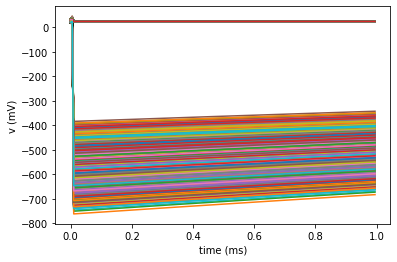

In [22]:
brian_plot(V)

## other parameters, adding a synaptic conductance, etc.

In [15]:
#define network parameters

#total size of the network
N = 40000

#threshold
theta = 33*mV

#reset voltage
v_reset = 24.75*mV

#indices that delimit inhibitory and excitatory populations 20/80
first_inh = 0
last_inh = int(0.2*N)
first_exc = last_inh
last_exc = N


#these are additional parameters to play with resizing of weights (in paper would be 1)
#g_E = 1/0.8*N
#g_I = 1/0.2*N
g_E = 1
g_I = 1


#clear brian scope to reset any past variables
start_scope()

#define the model that each neuron will follow
tau = 10*ms
tau_h = 1*ms
eqs = '''
dv/dt = -(v - H_tot)/tau : volt (unless refractory)
dh/dt = -h/tau_h : volt
H_tot = H + g_0*h : volt
g_0 : 1
H : volt
'''

#the original network is defined
all_neurons = NeuronGroup(N, eqs, threshold = 'v>33*mV', reset = 'v=24.75*mV', refractory = 1*ms, method = 'exact')
#all_neurons.v = '(10 + 14*rand())*mV'

#to work with subpopulations bria-n uses slicing notation
in_neurons = all_neurons[first_inh:last_inh]
ex_neurons = all_neurons[first_exc:last_exc]

in_neurons.v = '(30 + 3*rand())*mV'
ex_neurons.v = '(25 + 12.8*rand())*mV'

#define external drive according to supp table 1
in_neurons.H = '57.8*mV'
ex_neurons.H = '77.6*mV'
#in_neurons.H = '(24 + 9.1*rand())*mV'
#ex_neurons.H = '(24 + 9.1*rand())*mV'


#initialize the synaptic object for the different subpopulation pairs
S_EE = Synapses(ex_neurons, ex_neurons, 'w : volt', on_pre ='h += w')
S_IE = Synapses(ex_neurons, in_neurons, 'w : volt', on_pre ='h += w')
S_EI = Synapses(in_neurons, ex_neurons,'w : volt', on_pre ='h -= w')
S_II = Synapses(in_neurons, in_neurons, 'w : volt', on_pre ='h -= w')


#connect them according to probabilities in supp table 1
S_EE.connect(p = 0.2)
S_IE.connect(p = 0.3)
S_EI.connect(p = 0.4)
S_II.connect(p = 0.4)

#distribute them log-normal according to parameters obtained in processing cells (beginning of notebook)
S_EE.w = 'g_E*exp(ee_mu + ee_std*randn())*mV'
S_IE.w = 'g_E*exp(ie_mu + ie_std*randn())*mV'
S_EI.w = 'g_I*exp(ei_mu + ei_std*randn())*mV'
S_II.w = 'g_I*exp(ii_mu + ii_std*randn())*mV'



#define monitoring variables. these can monitor the whole population or a desired subpopulation

#monitors spiking events
M = SpikeMonitor(all_neurons)

#monitors voltage with time
V = StateMonitor(all_neurons, 'v', record = True)

In [16]:
total_time = 50*ms

start = time.time()

run(total_time)

end = time.time()
time_elapsed = end - start

print(time_elapsed)

3028.1133830547333


<AxesSubplot:xlabel='time (ms)', ylabel='v (mV)'>

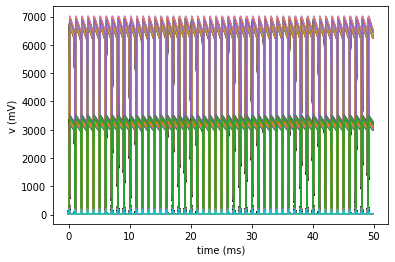

In [18]:
brian_plot(V)

In [20]:
#define network parameters

#total size of the network
N = 40000

#threshold
theta = 33*mV

#reset voltage
v_reset = 24.75*mV

#indices that delimit inhibitory and excitatory populations 20/80
first_inh = 0
last_inh = int(0.2*N)
first_exc = last_inh
last_exc = N


#these are additional parameters to play with resizing of weights (in paper would be 1)
#g_E = 1/0.8*N
#g_I = 1/0.2*N
g_E = 1
g_I = 1


#clear brian scope to reset any past variables
start_scope()

#define the model that each neuron will follow
tau = 10*ms
eqs = '''
dv/dt = -(v - H)/tau : volt

H : volt
'''

#the original network is defined
all_neurons = NeuronGroup(N, eqs, threshold = 'v>33*mV', reset = 'v=24.75*mV', refractory = 1*ms, method = 'exact')
all_neurons.v = '(0 + 33*rand())*mV'

#to work with subpopulations brian uses slicing notation
in_neurons = all_neurons[first_inh:last_inh]
ex_neurons = all_neurons[first_exc:last_exc]

#define external drive according to supp table 1
in_neurons.H = '57.8*mV'
ex_neurons.H = '77.6*mV'
#in_neurons.H = '(24 + 9.1*rand())*mV'
#ex_neurons.H = '(24 + 9.1*rand())*mV'


#initialize the synaptic object for the different subpopulation pairs
S_EE = Synapses(ex_neurons, ex_neurons, 'w : volt', on_pre ='v += w')
S_IE = Synapses(ex_neurons, in_neurons, 'w : volt', on_pre ='v += w')
S_EI = Synapses(in_neurons, ex_neurons,'w : volt', on_pre ='v += w')
S_II = Synapses(in_neurons, in_neurons, 'w : volt', on_pre ='v += w')


#connect them according to probabilities in supp table 1
S_EE.connect(p = 0.2)
S_IE.connect(p = 0.3)
S_EI.connect(p = 0.4)
S_II.connect(p = 0.4)

#distribute them log-normal according to parameters obtained in processing cells (beginning of notebook)
S_EE.w = 'g_E*exp(ee_mu + ee_std*randn())*mV'
S_IE.w = 'g_E*exp(ie_mu + ie_std*randn())*mV'
S_EI.w = 'g_I*exp(ei_mu + ei_std*randn())*mV'
S_II.w = 'g_I*exp(ii_mu + ii_std*randn())*mV'



#define monitoring variables. these can monitor the whole population or a desired subpopulation

#monitors spiking events
M = SpikeMonitor(all_neurons)

#monitors voltage with time
V = StateMonitor(all_neurons, 'v', record = True)

In [21]:
total_time = 50*ms

start = time.time()

run(total_time)

end = time.time()
time_elapsed = end - start

print(time_elapsed)

4480.4827291965485


<AxesSubplot:xlabel='time (ms)', ylabel='v (mV)'>

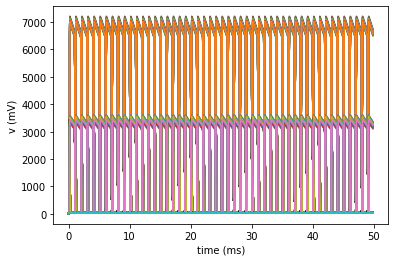

In [22]:
brian_plot(V)

In [264]:
#define network parameters

N = 40000


first_inh = 0
last_inh = int(0.2*N)

first_exc = last_inh
last_exc = N


#g_E = 1/0.8*N
#g_I = 1/0.2*N

g_E = 1
g_I = 1
g_H = 0.6
#generate network

start_scope()

tau_m = 10*ms
tau_h = 0.00015*ms
eqs = '''
dv/dt = -(v - H_tot)/tau_m : volt
dh/dt = -h/tau_h : volt
H_tot = H + g_0*h : volt
g_0 : 1
H : volt
W_EE : volt
W_IE : volt
W_EI : volt
W_II : volt
'''

all_neurons = NeuronGroup(N, eqs, threshold = 'v>33*mV', reset = 'v=24.75*mV', refractory = 1*ms)
all_neurons.v = '(27 + randn())*mV'
all_neurons.g_0 = 0.005
all_neurons.h = 0.1*mV

in_neurons = all_neurons[first_inh:last_inh]
ex_neurons = all_neurons[first_exc:last_exc]

in_neurons.H = 'g_H*57.8*mV'
ex_neurons.H = 'g_H*77.6*mV'

#in_neurons.H = '(35 + 4*randn())*mV'
#ex_neurons.H = '(27 + 4*randn())*mV'



ex_neurons.W_EE = 'g_E*exp(ee_mu + ee_std*randn())*mV'
in_neurons.W_IE = 'g_E*exp(ie_mu + ie_std*randn())*mV'
ex_neurons.W_EI = 'g_I*exp(ei_mu + ei_std*randn())*mV'
in_neurons.W_II = 'g_I*exp(ii_mu + ii_std*randn())*mV'


S_EE = Synapses(ex_neurons, ex_neurons, on_pre ='h += W_EE')
S_IE = Synapses(ex_neurons, in_neurons, on_pre ='h += W_IE')
S_EI = Synapses(in_neurons, ex_neurons, on_pre ='h -= W_EI')
S_II = Synapses(in_neurons, in_neurons, on_pre ='h -= W_II')

S_EE.connect(p = 0.2)
S_IE.connect(p = 0.3)
S_EI.connect(p = 0.4)
S_II.connect(p = 0.4)






M = SpikeMonitor(all_neurons)
V = StateMonitor(all_neurons, 'v', record = True)
H_in = StateMonitor(in_neurons, 'H_tot', record = True)
H_ex = StateMonitor(ex_neurons, 'H_tot', record = True)

In [265]:
total_time = 20*ms

start = time.time()

run(total_time)

end = time.time()
time_elapsed = end - start

print(time_elapsed)

514.8296887874603


<AxesSubplot:xlabel='time (ms)', ylabel='neuron index'>

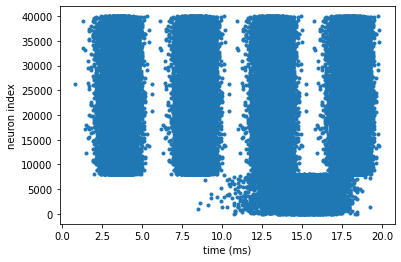

In [272]:
brian_plot(M)